In [21]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 

import tensorflow as tf 
import keras 
from keras import layers
df = pd.read_csv("../datasets/Task_1/10.csv")
df = df.drop("ID",axis=1)
df.head()
X = df.drop(["Price"], axis=1)
y = df["Price"]

In [22]:
correlations = df.corr(numeric_only=True)
correlations

,Price,Levy,Manufacturer,Prod. year,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,...,Category_2,Category_3,Category_4,Category_5,Category_6,Category_7,Category_8,Category_9,Category_10,Category_11
Price,1.00,0.07,-0.07,0.31,0.10,0.00,-0.02,0.01,-0.06,-0.02,...,-0.11,-0.17,-0.01,-0.05,0.07,0.01,0.06,0.02,-0.01,0.02
Levy,0.07,1.00,-0.13,0.38,0.01,0.15,-0.03,0.27,-0.37,-0.18,...,-0.21,-0.03,-0.06,-0.05,0.01,-0.02,-0.01,0.00,-0.03,0.01
Manufacturer,-0.07,-0.13,1.00,-0.21,0.04,-0.01,0.03,-0.01,0.15,-0.03,...,-0.05,-0.04,-0.03,0.01,-0.01,0.04,-0.01,0.04,0.05,0.03
Prod. year,0.31,0.38,-0.21,1.00,-0.05,-0.00,-0.07,-0.13,-0.52,-0.10,...,-0.04,0.08,-0.15,-0.14,-0.02,-0.08,-0.06,-0.04,-0.16,-0.01
Fuel type,0.10,0.01,0.04,-0.05,1.00,0.04,0.02,0.01,-0.01,0.04,...,-0.22,0.04,0.05,0.04,0.05,-0.03,0.12,-0.01,-0.00,0.01
Engine volume,0.00,0.15,-0.01,-0.00,0.04,1.00,-0.00,0.11,-0.02,-0.03,...,-0.05,0.01,0.00,-0.01,-0.00,0.01,0.00,0.01,0.00,0.00
Mileage,-0.02,-0.03,0.03,-0.07,0.02,-0.00,1.00,-0.00,0.05,0.01,...,-0.00,0.01,-0.00,-0.00,-0.00,-0.00,-0.01,-0.00,-0.00,-0.00
Cylinders,0.01,0.27,-0.01,-0.13,0.01,0.11,-0.00,1.00,-0.03,-0.24,...,-0.19,-0.06,-0.02,-0.04,-0.06,0.06,-0.05,0.04,0.03,0.01
Gear box type,-0.06,-0.37,0.15,-0.52,-0.01,-0.02,0.05,-0.03,1.00,0.17,...,0.11,-0.03,0.22,0.22,0.03,0.08,-0.01,0.02,0.03,0.04
Drive wheels,-0.02,-0.18,-0.03,-0.10,0.04,-0.03,0.01,-0.24,0.17,1.00,...,0.06,0.26,0.13,0.04,0.02,0.16,0.03,0.06,0.03,-0.01


In [23]:
#this doesnt finish for some reason, just runs forever

#from skfeature.function.similarity_based import fisher_score

# get the fisher's score rankings 
#ranks = fisher_score.fisher_score(X.values, y.values)

# create a pandas DataFrame for easier interpretation
#feat_importances = pd.Series(ranks, X.columns)
#feat_importances.plot(kind='barh')

# how to interpret -> low score means the effect of this field is not large in the dataset
# => typically means other columns in the dataset have similar correlations, 
# therefore making this particular column not so useful since other columns 
# already fill this role for this correlation

# Fisher's score studies the variance of the data -> statistical significance'

# based on Fisher's score:
# num_rooms is not important at all, and num_people has minor importance in this data
# but ave_monthly_income is quite powerful based on Fisher's score

In [24]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

# initialize chi2 and SelectKBest
# Note: chi2 -test is a very common test
# in statistics and quantitative analysis
# basically it studies the data whether variables are related
# or independent of each other
chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_2_features.fit(X_cat,y.astype(int))

# use decimal format in table print later
pd.options.display.float_format = '{:.2f}'.format

# wrap it up, and show the results
# the higher the score, the more effect that column has on target variable
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

,Features,Score
5,Mileage,2257073608170.39
0,Levy,1953331.78
1,Manufacturer,18387.91
9,Airbags,12591.47
17,Category_8,6256.01
15,Category_6,6147.20
4,Engine volume,5432.57
16,Category_7,3888.23
10,Category_1,3558.55
11,Category_2,2777.36


In [25]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)

# step 2, split the temporary data in HALF (0.5) => 15% test and 15% validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [26]:
# create neural network

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# save the amount of support variables into a helper variable
# so we don't have to update the input_shape all the time
variable_amount = len(X.columns)

# create callbacks and place them into a parameter list
# NOTE! if you get PermissionError while training the model,
# just try training it again
mc = ModelCheckpoint('best_model_regression1_cars.keras', monitor='val_loss', mode='min', save_best_only=True)

# if you use multiple callbacks (EarlyStoppin, ReduceLROnPlateau etc.)
# add them to this same list
callback_list = [mc]

# let's try some common optimization approaches

# neural networks often need at least a normalization layer
# so that it updates all weight values fairly 
# typically the original dataset has various scales of numbers
# which confuses neural network while it's training itself
# luckily we have the BatchNormalization -layer in keras!

# regularization is often beneficial in neural networks
# but it's usually better to apply this a bit later
# once you know approximately a working neural network structure for your data
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(variable_amount,)),
        layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.1)),
        layers.Dropout(0.1),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)
    ]
)

# select the optimizer and loss function
# you can try rmsprop also as optimizer, or stochastic gradient descent
model.compile(optimizer='adam', loss='mse')

# common tips on how to change neural network structure if your metrics are not good:
#####################################################################################
# make wider (or narrower) layers (for example, 64 or 128 nodes)
# make a longer or shorter network (add or remove layers)
# use Dropout -layers (e.g. layers.Dropout(0.1))

# remember: there's no process or mathematical formula
# in order to figure out the optimal neural network structure
# it's mostly all about trial and error => EXPERIMENTATION!

# remember to have enough "decision-space" for your data!
# it's highly unlikely a dataset with 20 different variables is going
# to work well with only 8 nodes in each layer etc.

# print out the summary of your model
model.summary()

/home/lukas/dev/venvs/DL/lib/python3.12/site-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 21)             │            84 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,269 (51.83 KB)

 Trainable params: 13,227 (51.67 KB)

 Non-trainable params: 42 (168.00 B)

In [27]:
model.fit(x=X_train, y=y_train, epochs=1200, validation_data=(X_val, y_val), callbacks=callback_list)

Epoch 1/1200
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 324806336.0000 - val_loss: 2006177280.0000
Epoch 2/1200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 172486368.0000 - val_loss: 172630624.0000
Epoch 3/1200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 163570720.0000 - val_loss: 156970656.0000
Epoch 4/1200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 159620864.0000 - val_loss: 153946240.0000
Epoch 5/1200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 158478672.0000 - val_loss: 151639392.0000
Epoch 6/1200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 155530752.0000 - val_loss: 148994912.0000
Epoch 7/1200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 153015680.0000 - val_loss: 149468208.0000
Epoch 8/1200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 151618704.0000 - val_loss: 146873872.0000
Epoch 9/1200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 149902176.0000 - val_loss: 145029504.0000
Epoch 10/1200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 

<Axes: >

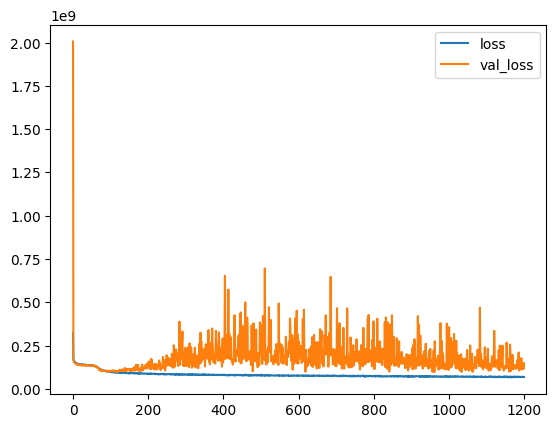

In [28]:
# let's use pandas for this (easy code)
# try to look if the model is actually training 
# => the error is going downwards
# if using validation data, you get two lines
# in this case, see if the lines follow a similar trend 
# (they don't always overlap with complex data, the trend is more important)
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [29]:
from keras.models import load_model
model = load_model("best_model_regression1_cars.keras")

In [30]:
# compare the final model loss/evaluation values
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
94783376.0

Train data evaluation:
114796816.0


In [31]:
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Test True Y,Model Predictions
0,15681,9395.78
1,706,3809.13
2,25889,35211.00
3,21181,21276.91
4,1882,7875.97
...,...,...
2445,23678,20553.10
2446,40983,44295.66
2447,23722,22279.29
2448,10663,19034.24


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

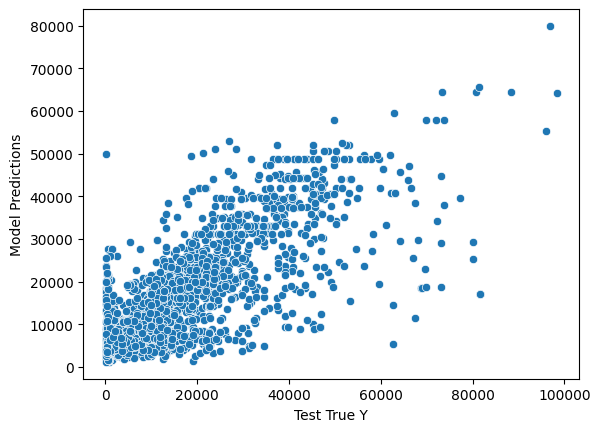

In [32]:
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

In [33]:
# MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
6436.22 $

MSE
94783248.0 $^2

RMSE:
9735.67 $

R-squared:
0.57

Explained variance score:
0.58


In [34]:
#i dont quite understand the error source for the error below (tester_row) so I asked chatgpt and It gave me this code, it does not really help me any forward though.
common_indices = y_test.index.intersection(test_predictions.index)
unique_to_y_test = y_test.index.difference(test_predictions.index)
unique_to_test_predictions = test_predictions.index.difference(y_test.index)

print("Common indices:", common_indices)
print("Indices only in y_test:", unique_to_y_test)
print("Indices only in test_predictions:", unique_to_test_predictions)

print("y_test indices:", y_test.index)
print("test_predictions indices:", test_predictions.index)

# so apparently the problem is that there are rows (indices) in the testing data that are not in predictions data?
# Or there is a different amount of testing and prediction data?
# I dont understand how this is a problem now since it worked before and I also cant figure out how to fix it. 


Common indices: MultiIndex([], )
Indices only in y_test: MultiIndex([( 4214,  4214),
            ( 5974,  5974),
            (12793, 12793),
            ( 4394,  4394),
            ( 3510,  3510),
            ( 8295,  8295),
            (14690, 14690),
            (11262, 11262),
            (11383, 11383),
            ( 6629,  6629),
            ...
            (12115, 12115),
            (13790, 13790),
            ( 6744,  6744),
            ( 7819,  7819),
            ( 9624,  9624),
            (13298, 13298),
            (13950, 13950),
            (11356, 11356),
            ( 6412,  6412),
            ( 3892,  3892)],
           length=2450)
Indices only in test_predictions: Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449],
      dtype='int64', length=2450)
y_test indices: MultiIndex([( 4214,  4214),
            ( 5974,  5974),
            (12793, 12793),
            ( 4394,  4394),


In [35]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

ValueError: cannot join with no overlapping index names

In [ ]:
tester_row = {
    'Levy': 0, 
    'Manufacturer': 12, 
    'Prod. year': 2025,
    'Category_1': 0, 
    'Category_2': 0, 
    'Category_3': 0, 
    'Category_4': 0, 
    'Category_5': 0, 
    'Category_6': 0, 
    'Category_7': 0, 
    'Category_8': 0, 
    'Category_9': 0, 
    'Category_10': 0, 
    'Category_11': 1, 
    'Fuel type': 2, 
    'Engine volume': 2.0, 
    'Mileage': 0,
    'Cylinders': 4.0,
    'Gear box type': 4,
    'Drive wheels': 3,
    'Airbags': 5
}

tester_row = pd.DataFrame([tester_row])

In [41]:
result = model.predict(tester_row)[0]

print()
print(f"Estimated car price with this example:")
print(f"$ {round(float(result[0]), 2)}")
print("----------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Estimated car price with this example:
$ 983495.81
----------------
